## Enunciado

Considere el proyecto cuya información se adjunta.
 1. Determine para cada actividad su duración optimista. ¿Influye esta duración optimista en la duración mínima del proyecto?
 2. Determine duración media del proyecto y su varianza utilizando para ello la aproximación del teorema del límite central.
 3. Determine la probabilidad de que el proyecto se termine antes de 10 periodos.
 4. Planifique el proyecto teniendo en cuenta que durante las primeras tres semanas dispondrá de cuatro trabajadores y a partir de la cuarta de seis trabajadores.
 5. ¿Sería suficiente disponer de 4 recursos durante todo el proyecto? ¿Por qué?



In [1]:
%%capture
from jupyter_tikz import TexFragment
import os, sys
from IPython.display import display, HTML, Markdown


"""
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"


if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files
"""
# To find local version of the library
sys.path.append('../src')

from pmule import PredecessorTable, ProjectGraph
%mkdir -p ~/temp
%cd ~/temp

In [2]:
import pandas as pd
import numpy as np

datos_enunciado = pd.DataFrame([
#  nombre, anteriores, duracion, duracion_pesimista, duracion_modal, recursos
     ('A',       '---  ',     2,         2,                    2,           1  ),
     ('B',       'A    ',     2,         3,                    2,           2  ),
     ('C',       'B    ',     3,         4,                    3,           2  ),
     ('D',       'B,J  ',     4,         5,                 17/4,           1  ),
     ('E',       'F,B,J',     1,         1,                    1,           1  ),
     ('F',       'A    ',     2,         3,                    2,           2  ),
     ('G',       'C,D  ',     1,         1,                    1,           1  ),
     ('H',       'E    ',     4,         5,                    4,           1  ),
     ('I',       'B,J  ',     1,         1,                    1,           1  ),
     ('J',       'A    ',     2,         2,                    2,           1  ),
] ,columns=['activity', 'predecessor', 'duration', 'pesimistic_duration', 'modal_duration', 'resources'])
datos_enunciado.set_index('activity', inplace=True)
datos_enunciado

,predecessor,duration,pesimistic_duration,modal_duration,resources
activity,,,,,
A,---,2,2,2.00,1
B,A,2,3,2.00,2
C,B,3,4,3.00,2
D,"B,J",4,5,4.25,1
E,"F,B,J",1,1,1.00,1
F,A,2,3,2.00,2
G,"C,D",1,1,1.00,1
H,E,4,5,4.00,1
I,"B,J",1,1,1.00,1


## Solución
### Apartado 1


A partir de los datos del enunciado y de la relación $D=\frac{a+4m+b}{6}$ obtenemos la duración optimista $a=6D-b-4m$.

In [3]:
datos_proyecto = datos_enunciado.copy()
datos_proyecto['optimistic_duration'] = datos_proyecto.eval('6*duration - pesimistic_duration - 4*modal_duration')
datos_proyecto

,predecessor,duration,pesimistic_duration,modal_duration,resources,optimistic_duration
activity,,,,,,
A,---,2,2,2.00,1,2.0
B,A,2,3,2.00,2,1.0
C,B,3,4,3.00,2,2.0
D,"B,J",4,5,4.25,1,2.0
E,"F,B,J",1,1,1.00,1,1.0
F,A,2,3,2.00,2,1.0
G,"C,D",1,1,1.00,1,1.0
H,E,4,5,4.00,1,3.0
I,"B,J",1,1,1.00,1,1.0


### Apartado 2


#### Duración media del proyecto

In [4]:
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J
activities,,,,,,,,,,
A,,,,,,,,,,
B,True,,,,,,,,,
C,,True,,,,,,,,
D,,True,,,,,,,,True
E,,True,,,,True,,,,True
F,True,,,,,,,,,
G,,,True,True,,,,,,
H,,,,,True,,,,,
I,,True,,,,,,,,True


La varianza de cada actividad no es aportada por el enunciado como dato, pero sí se puede calcular a partir de la expresión $\sigma^2 = \left(\frac{b-a}{6} \right)$

In [5]:
datos_proyecto['variance'] = ((datos_proyecto['pesimistic_duration'] - datos_proyecto['optimistic_duration'])/6)**2
datos_proyecto[['pesimistic_duration', 'optimistic_duration', 'variance']]

,pesimistic_duration,optimistic_duration,variance
activity,,,
A,2,2.0,0.000000
B,3,1.0,0.111111
C,4,2.0,0.111111
D,5,2.0,0.250000
E,1,1.0,0.000000
F,3,1.0,0.111111
G,1,1.0,0.000000
H,5,3.0,0.111111
I,1,1.0,0.000000


##### Grafo PERT con numeración de nodos

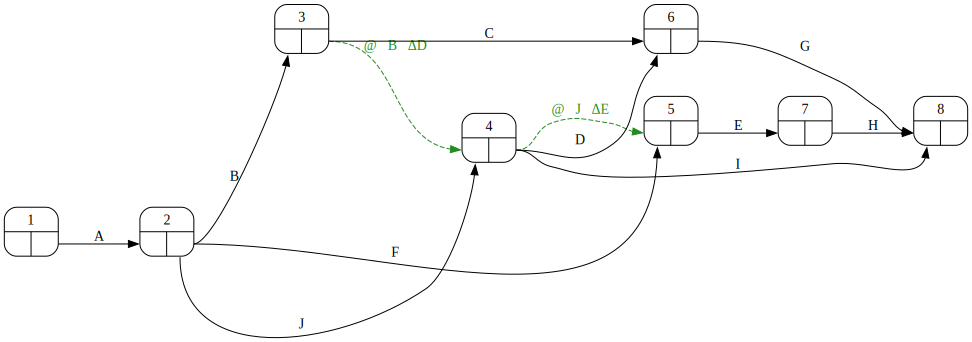

In [6]:
proyecto = prelaciones.create_project()
proyecto.pert(ranksep=1.0)

##### Matriz de Zaderenko

In [7]:
proyecto.zaderenko(durations=datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,early
1,,2.0,,,,,,,0.0
2,,,2.0,2.0,2.0,,,,2.0
3,,,,0.0,,3.0,,,4.0
4,,,,,0.0,4.0,,1.0,4.0
5,,,,,,,1.0,,4.0
6,,,,,,,,1.0,8.0
7,,,,,,,,4.0,5.0
8,,,,,,,,,9.0
late,0.0,2.0,4.0,4.0,4.0,8.0,5.0,9.0,


In [8]:
duraciones_medias = datos_proyecto['duration']
resultados_pert = proyecto.calculate_pert(durations=duraciones_medias)
resultados_pert['nodes'].T

,1,2,3,4,5,6,7,8
early,0,2,4,4,4,8,5,9
late,0,2,4,4,4,8,5,9


La duración media del proyecto es:

In [9]:
duracion_media_proyecto = int(proyecto.duration(durations=duraciones_medias))
duracion_media_proyecto

9

#### Varianza de la duración del proyecto
Para determinar la varianza de la duración del proyecto es necesario determinar la varianza de cada rama del camino crítico.

##### Holguras

In [10]:
resultados_pert['activities'][['H_total']].T

,@∇B⤑ΔD,@∇J⤑ΔE,A,B,C,D,E,F,G,H,I,J
H_total,0,0,0,0,1,0,0,0,0,0,4,0


##### Camino crítico

##### Grafo PERT con indicación del camino crítico

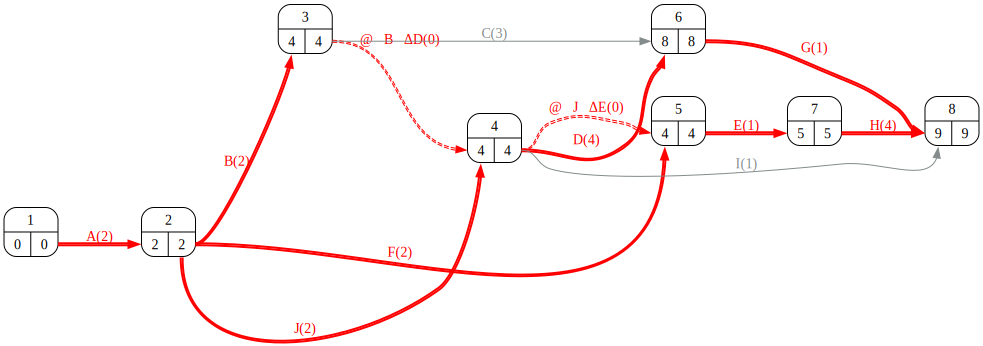

In [11]:
proyecto.pert(durations=duraciones_medias, ranksep=0.8)

In [12]:
camino_critico = proyecto.critical_path(durations=duraciones_medias)
for key, value in camino_critico.items():
    print(f"{key}: ", ", ".join(value))

Route_2:  A, B, D, G
Route_3:  A, B, E, H
Route_5:  A, E, F, H
Route_6:  A, D, G, J
Route_7:  A, E, H, J


##### Varianza del proyecto

In [13]:
desviacion_proyecto = proyecto.standard_deviation(durations = datos_proyecto['duration'],
                                                  variances = datos_proyecto['variance'])
Markdown(f"La desviación típica de la duración del proyecto es la máxima desviación típica de las rutas críticas. Para este proyecto es {round(desviacion_proyecto,2)}")

Variance path: Route_2 : 0.3611111111111111
Variance path: Route_3 : 0.2222222222222222
Variance path: Route_5 : 0.2222222222222222
Variance path: Route_6 : 0.25
Variance path: Route_7 : 0.1111111111111111
Project duration variance: 0.3611111111111111
Project duration standard deviation: 0.6009252125773316


La desviación típica de la duración del proyecto es la máxima desviación típica de las rutas críticas. Para este proyecto es 0.6

### Apartado 3

In [14]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_10 = norm.cdf(10, loc=duracion_media_proyecto, scale=desviacion_proyecto)
Markdown(f"Para un proyecto con duración media {duracion_media_proyecto} y desviación típica {round(desviacion_proyecto, 2)} el valor de la probabilidad pedida es {round(probabilidad_de_terminar_antes_de_10 * 100, 2)} por ciento.")

Para un proyecto con duración media 9 y desviación típica 0.6 el valor de la probabilidad pedida es 95.2 por ciento.

### Apartado 4

#### Análisis de la situación inicial

Para responder este apartado es necesario representar la demanda de recursos a lo largo del tiempo.

In [15]:
#!apt-get install -y texlive-latex-extra   > /dev/null
#!apt-get install -y poppler-utils         > /dev/null

In [16]:
datos_proyecto[['duration',
                'pesimistic_duration',
                'resources',
                'optimistic_duration']] = datos_proyecto[['duration', 'pesimistic_duration', 
                                                            'resources', 'optimistic_duration']].astype(int)

In [17]:
!ls ejercicio_02

gantt_01.pdf  gantt_02.pdf  gantt_03.pdf  gantt_04.pdf
gantt_01.tex  gantt_02.tex  gantt_03.tex  gantt_04.tex
gantt_01.tikz gantt_02.tikz gantt_03.tikz gantt_04.tikz


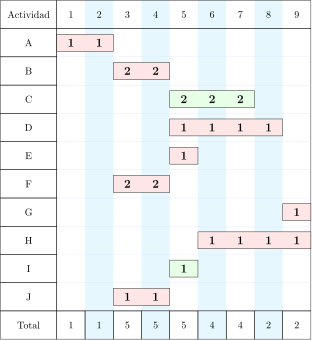

In [18]:
proyecto_asignacion = proyecto.copy()
gantt_df, dibujo = proyecto.gantt(datos_proyecto,
                      duration_label='duration',
                      resource_label='resources',
                      total='fila',
                      tikz=True,
                      params=dict(
                        period_width=1,
                        row_height=1,
                        #background_horizontal_line_color='gray',
                        #background_vertical_bars_color='white!92!cyan',
                        activity_relative_height=0.6,
                        critical_background_color='white!90!red',
                        regular_background_color='white!90!green',
                        regular_text_color='black',
                        critical_text_color='black',
                        activity_inner_text_style=r"\bfseries\large",),
                    )
from jupyter_tikz import TexFragment
filename = "ejercicio_02/gantt_01"
TexFragment(dibujo).run_latex(save_tikz=filename, save_pdf=filename, save_tex=filename, full_err=True)

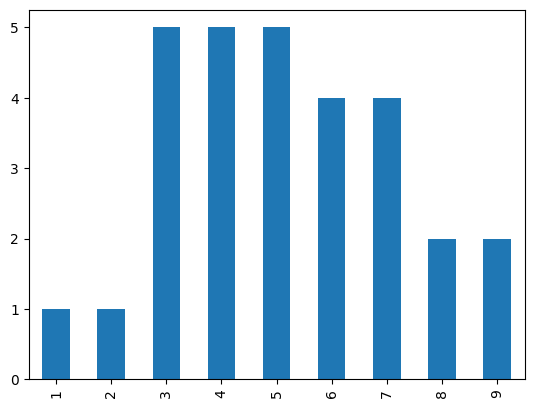

In [19]:
#| label: tbl-barras-recursos
#| tbl-cap: "Consumo de recursos en los distintos periodos"
gantt_df.data.loc['Total'].plot(kind='bar');

La demanda de recursos actual infringe el límite impuesto en el enunciado. Es necesario aplicar el algoritmo de asignación.

#### Reprogramación del proyecto utilizando el algoritmo de asignación

 El primer periodo problemático es el 3.

##### Asignación periodo 3

Las tres actividades programadas para el periodo 3 son críticas y de la misma duración. Al disponer de 4 recursos máximo se programan las actividades B y F desplazando la J.

Suma de cuadrados: 105 



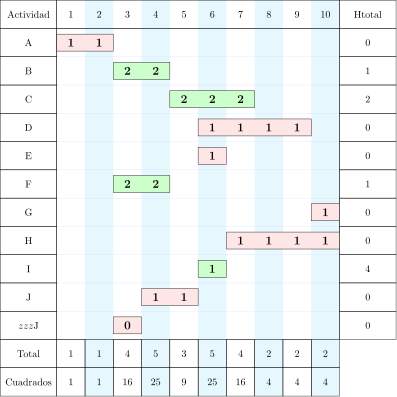

In [20]:
duracion_y_recursos = datos_proyecto[['duration', 'resources']].copy()
duracion_y_recursos, gantt_df, dibujo = proyecto_asignacion.desplazar(duracion_y_recursos, 'duration',  'resources', tikz=True, 
            params=dict(
                        period_width=1,
                        row_height=1,
                        #background_horizontal_line_color='black',
                        activity_relative_height=0.6,
                        critical_background_color='white!90!red',
                        regular_background_color='white!80!green',
                        regular_text_color='black',
                        critical_text_color='black',
                        vertical_bar_background_color='black',
                        activity_inner_text_style=r"\bfseries\large",),  
            J = 1)
filename = "ejercicio_02/gantt_02"
TexFragment(dibujo.replace('💤',r'$zzz$')).run_latex(save_tikz=filename, save_pdf=filename, save_tex=filename, full_err=True)

La actividad *💤J* representa el desplazamiento de las actividad J.

En estas condiciones el proyecto ya es compatible con las restricciones impuestas a los recursos.

### Apartado 5

En la programación resultante del apartado anterior los cuatro recursos no serían suficientes pues hay periodos que demandan 5 recursos. Se analiza la posibilidad de reprogramar el proyecto atendiendo a este nuevo límite.

#### Reprogramación del proyecto utilizando el algoritmo de asignación

 El primer periodo problemático es el 4.

##### Asignación periodo 4

Las tres actividades programadas para el periodo 4 son críticas y de la misma duración. Sin embargo las actividades y B y F ya han comenzado su ejecución y se opta por no interrumpirlas. Se desplaza por tanto la J.

Suma de cuadrados: 93 



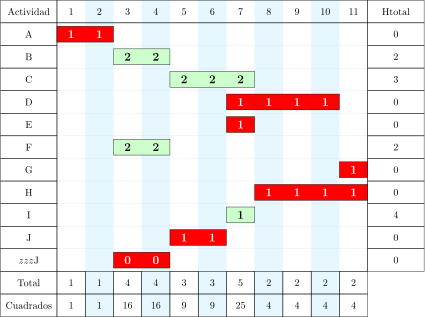

In [21]:
duracion_y_recursos, gantt_df, dibujo = proyecto_asignacion.desplazar(duracion_y_recursos, 'duration', 'resources', tikz=True, J = 1)
filename = "ejercicio_02/gantt_03"
TexFragment(dibujo.replace('💤',r'$zzz$')).run_latex(save_tikz=filename, save_pdf=filename, save_tex=filename, full_err=True)

El siguiente periodo conflictivo sería el 7.

##### Asignación periodo 7

Las D y E son críticas. Entre ambas consumen dos recursos. De las dos actividades no críticas se opta por desplazar la I por ser la de mayor holgura. La actividad C es posible programarla para este periodo al consumir otros dos recurssos.

Suma de cuadrados: 89 



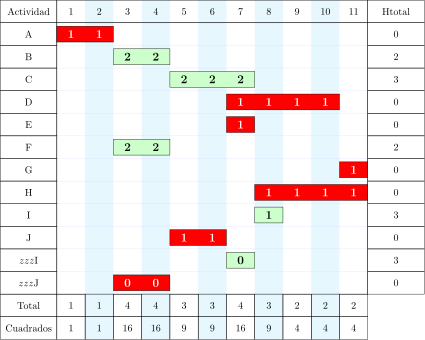

In [22]:
duracion_y_recursos, gantt_df, dibujo = proyecto_asignacion.desplazar(duracion_y_recursos, 'duration', 'resources', tikz=True, I = 1)
filename = "ejercicio_02/gantt_04"
TexFragment(dibujo.replace('💤',r'$zzz$')).run_latex(save_tikz=filename, save_pdf=filename, save_tex=filename, full_err=True)

En estas condiciones el proyecto ya es viable con 4 recursos. No obstante su duración se ha prolongado hasta 11 periodos.